In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
torch.manual_seed(42)

In [4]:
import spacy

In [5]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [6]:
nlp.max_length = 1500000

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [8]:
import nltk

In [9]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline

In [10]:
from nltk.corpus import gutenberg

In [11]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [12]:
def preprocess_data(vocab_size=3000, seq_length=20, target_sequences=10000):
    print("Loading dataset...")
    # Load "The Adventures of Sherlock Holmes" from Gutenberg
    alice_text = gutenberg.raw("carroll-alice.txt")
    macbeth_text = gutenberg.raw("shakespeare-macbeth.txt")
    combined_text = alice_text + " " + macbeth_text
    print(f"Total characters in text: {len(combined_text)}")

    # Tokenize
    print("Tokenizing...")
    tokens = []
    for doc in nlp.pipe([combined_text], batch_size=1000):
        tokens.extend([token.text.lower() for token in doc if not token.is_space])
    print(f"Total tokens: {len(tokens)}")

    tokens_needed = target_sequences + seq_length  
    if len(tokens) < tokens_needed:
        repeat_factor = (tokens_needed // len(tokens)) + 1
        tokens = (tokens * repeat_factor)[:tokens_needed]
        print(f"Repeated text to reach {len(tokens)} tokens for ~{target_sequences} sequences")
    else:
        tokens = tokens[:tokens_needed]
        print(f"Subsampled to {len(tokens)} tokens for ~{target_sequences} sequences")

    # Build vocabulary
    print("Building vocabulary...")
    word_counts = Counter(tokens)
    vocab = ["<unk>"] + [word for word, _ in word_counts.most_common(vocab_size - 1)]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}

    # Convert to numerical sequences
    print("Converting to sequences...")
    sequences = []
    for i in range(0, len(tokens) - seq_length):
        seq = tokens[i:i + seq_length + 1]
        seq_ids = [word2idx.get(word, 0) for word in seq]  
        sequences.append(seq_ids)

    # Split into train and test
    sequences = np.array(sequences)
    train_size = int(0.9 * len(sequences))
    train_seqs = sequences[:train_size]
    test_seqs = sequences[train_size:]

    return train_seqs, test_seqs, word2idx, idx2word, vocab

In [13]:
train_seqs, test_seqs, word2idx, idx2word, vocab = preprocess_data(vocab_size=5000, seq_length=20, target_sequences=100000)

print(f"Vocabulary size: {len(vocab)}")
print(f"Number of training sequences: {len(train_seqs)}")
print(f"Number of test sequences: {len(test_seqs)}")
print(f"Sample tokens: {vocab[:10]}")

Loading dataset...
Total characters in text: 244747
Tokenizing...
Total tokens: 56703
Repeated text to reach 100020 tokens for ~100000 sequences
Building vocabulary...
Converting to sequences...
Vocabulary size: 5000
Number of training sequences: 90000
Number of test sequences: 10000
Sample tokens: ['<unk>', ',', "'", 'the', '.', 'and', 'to', 'a', 'i', 'of']


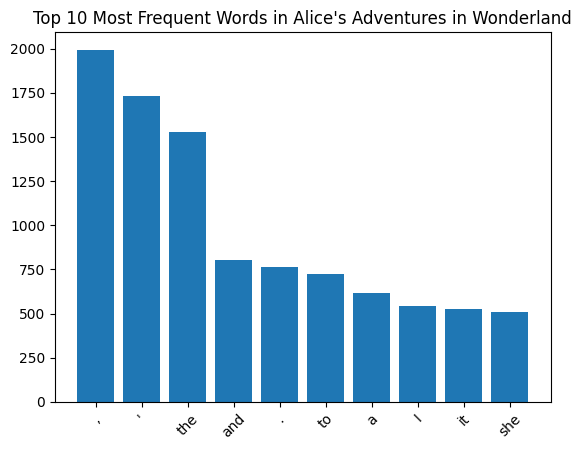

In [14]:
# visualizing word frequencies
word_counts = Counter(gutenberg.words("carroll-alice.txt"))
top_words = dict(word_counts.most_common(10))
plt.bar(top_words.keys(), top_words.values())
plt.title("Top 10 Most Frequent Words in Alice's Adventures in Wonderland")
plt.xticks(rotation=45)
plt.show()

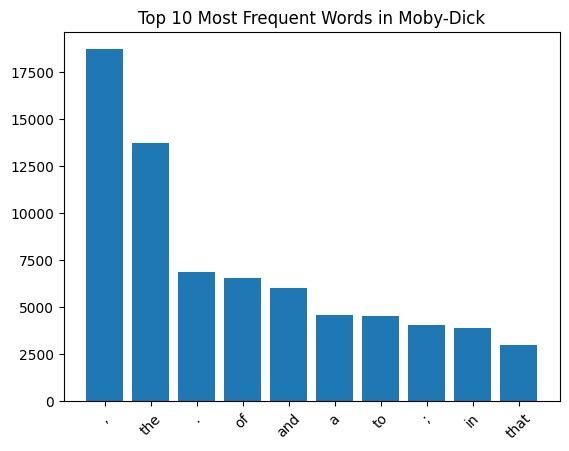

In [15]:
word_counts = Counter(gutenberg.words("melville-moby_dick.txt"))
top_words = dict(word_counts.most_common(10))
plt.bar(top_words.keys(), top_words.values())
plt.title("Top 10 Most Frequent Words in Moby-Dick")
plt.xticks(rotation=45)
plt.show()

In [16]:
#LSTM model
class TextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=256, num_layers=2, dropout=0.3):
        super(TextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

In [17]:
# Initialize model
vocab_size = len(vocab)
model = TextGenerator(vocab_size=vocab_size, embed_size=64, hidden_size=128, num_layers=1, dropout=0.3)
print(model)

TextGenerator(
  (embedding): Embedding(5000, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=5000, bias=True)
)


In [18]:
# 3. Train the Model with Comparison
def train_model(model, train_data, test_data, vocab_size, seq_length, epochs=10, batch_size=128):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  

    train_losses = []
    test_perplexities = []
    best_perplexity = float("inf")
    patience = 2
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i in range(0, len(train_data) - batch_size, batch_size):
            batch = train_data[i:i + batch_size]
            inputs = torch.tensor(batch[:, :-1], dtype=torch.long).to(device)
            targets = torch.tensor(batch[:, 1:], dtype=torch.long).to(device)

            optimizer.zero_grad()
            output, _ = model(inputs)
            loss = criterion(output.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / (len(train_data) // batch_size)
        train_losses.append(avg_loss)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i in range(0, len(test_data) - batch_size, batch_size):
                batch = test_data[i:i + batch_size]
                inputs = torch.tensor(batch[:, :-1], dtype=torch.long).to(device)
                targets = torch.tensor(batch[:, 1:], dtype=torch.long).to(device)
                output, _ = model(inputs)
                test_loss += criterion(output.view(-1, vocab_size), targets.view(-1)).item()
        perplexity = np.exp(test_loss / (len(test_data) // batch_size))
        test_perplexities.append(perplexity)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Test Perplexity: {perplexity:.2f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        if perplexity < best_perplexity:
            best_perplexity = perplexity
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step() 

    return model, train_losses, test_perplexities

In [34]:
num_layers_list = [1, 2]
all_train_losses = []
all_test_perplexities = []
models = {}

In [36]:
for num_layers in num_layers_list:
    print(f"\nTraining model with {num_layers} layer(s)...")
    model = TextGenerator(vocab_size=vocab_size, embed_size=64, hidden_size=128, num_layers=num_layers, dropout=0.3)
    model, train_losses, test_perplexities = train_model(model, train_seqs, test_seqs, vocab_size, seq_length=20, epochs=5, batch_size=64)
    all_train_losses.append(train_losses)
    all_test_perplexities.append(test_perplexities)
    models[num_layers] = model
    print(f"Final Perplexity with {num_layers} layer(s): {test_perplexities[-1]:.2f}")


Training model with 1 layer(s)...
Epoch 1, Loss: 5.1477, Test Perplexity: 410.24, LR: 0.005000
Epoch 2, Loss: 4.0046, Test Perplexity: 234.99, LR: 0.005000
Epoch 3, Loss: 3.2405, Test Perplexity: 147.33, LR: 0.002500
Epoch 4, Loss: 2.8195, Test Perplexity: 104.92, LR: 0.002500
Epoch 5, Loss: 2.5107, Test Perplexity: 71.96, LR: 0.001250
Final Perplexity with 1 layer(s): 71.96

Training model with 2 layer(s)...
Epoch 1, Loss: 5.4642, Test Perplexity: 680.17, LR: 0.005000
Epoch 2, Loss: 4.6263, Test Perplexity: 763.43, LR: 0.005000
Epoch 3, Loss: 4.1928, Test Perplexity: 483.98, LR: 0.002500
Epoch 4, Loss: 3.8524, Test Perplexity: 431.14, LR: 0.002500
Epoch 5, Loss: 3.6225, Test Perplexity: 363.58, LR: 0.001250
Final Perplexity with 2 layer(s): 363.58


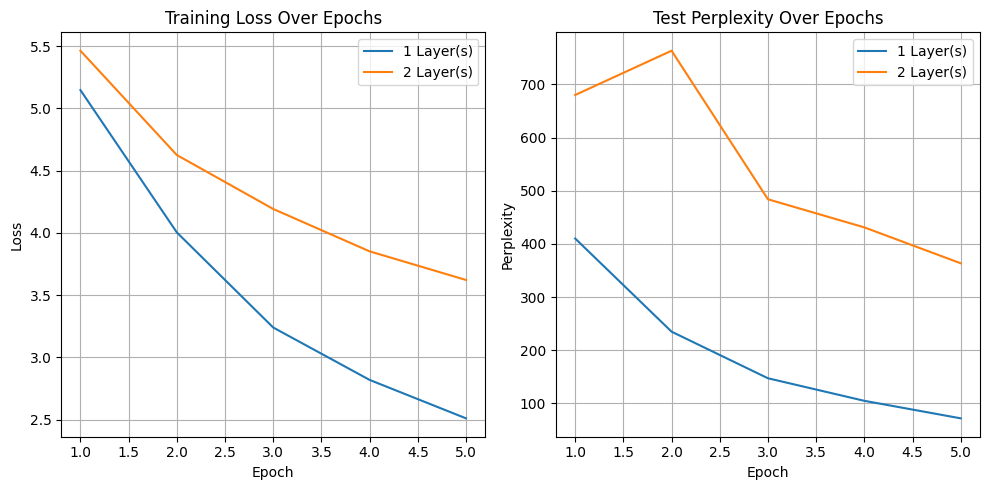

In [38]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i, num_layers in enumerate(num_layers_list):
    plt.plot(range(1, len(all_train_losses[i]) + 1), all_train_losses[i], label=f"{num_layers} Layer(s)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i, num_layers in enumerate(num_layers_list):
    plt.plot(range(1, len(all_test_perplexities[i]) + 1), all_test_perplexities[i], label=f"{num_layers} Layer(s)")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Test Perplexity Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
best_num_layers = num_layers_list[np.argmin([perplexities[-1] for perplexities in all_test_perplexities])]
model = models[best_num_layers]
print(f"Best model: {best_num_layers} layer(s) with final perplexity {all_test_perplexities[num_layers_list.index(best_num_layers)][-1]:.2f}")

Best model: 1 layer(s) with final perplexity 71.96


In [42]:
print(f"final loss: {train_losses[-1]}")

final loss: 3.62248784329101


In [44]:
torch.save(model.state_dict(), "text_generator.pth")
print("Model saved to text_generator.pth")

Model saved to text_generator.pth


In [46]:
from torchviz import make_dot

In [48]:
# Create a sample input (batch_size=1, seq_length=20)
sample_input = torch.zeros(1, 20, dtype=torch.long).to(device)  # Shape: (batch_size, seq_length)

In [50]:
model.eval()
with torch.no_grad():
    output, _ = model(sample_input)

In [52]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz-13.0.0-win32\bin"

In [54]:
graph = make_dot(output, params=dict(model.named_parameters()))
graph.render("text_generator_graph", format="png", cleanup=True)  # Saves as text_generator_graph.png
print("Computational graph saved as text_generator_graph.png")

Computational graph saved as text_generator_graph.png


In [55]:
from IPython.display import Image

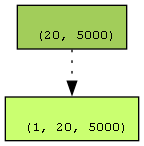

In [56]:
Image("text_generator_graph.png")

In [60]:
# generate text
def generate_text(model, word2idx, idx2word, seed_text, gen_length=50, top_k=5):
    model.eval()
    words = seed_text.lower().split()
    input_ids = [word2idx.get(word, 0) for word in words[-20:]]  
    generated = words

    with torch.no_grad():
        hidden = None
        for _ in range(gen_length):
            input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
            output, hidden = model(input_tensor, hidden)
            probs = torch.softmax(output[0, -1], dim=-1)
            top_k_probs, top_k_ids = torch.topk(probs, top_k)
            next_id = top_k_ids[torch.multinomial(top_k_probs, 1)].item()
            generated.append(idx2word[next_id])
            input_ids = input_ids[1:] + [next_id]

    return " ".join(generated)

In [62]:
seed_texts = ["The sun sets slowly", "In a world where"]
for seed_text in seed_texts:
    generated_text = generate_text(model, word2idx, idx2word, seed_text, gen_length=50)
    print(f"\nSeed: {seed_text}")
    print(f"Generated: {generated_text}")


Seed: The sun sets slowly
Generated: the sun sets slowly , ' that 's all the other . ' and i 've read about it , and the poor little thing was very nearly at first , the owl had disappeared . ' ' what is the matter ? ' the king said gravely . ' i ca n't remember

Seed: In a world where
Generated: in a world where ? ' the king hastily replied . ' i 've forgotten the hatter . ' not , ' i have you executed , ' said the hatter . ' ' you might just as you say . ' ' you are old , father william , ' said the king
